In [4]:
import tensorflow as tf
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
import os
import pickle
import keras
from keras import layers

from tensorflow.keras.applications.efficientnet import EfficientNetB0
from tensorflow.keras import applications, callbacks, layers, losses, metrics, models, optimizers, preprocessing

2023-04-14 17:16:17.088100: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-14 17:16:23.036383: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [5]:
# IMG_SHAPE= (32,32,3)
IMG_SHAPE = (28,28,3)
code_size = 32
BATCH_SIZE = 16

In [5]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
img_gen = ImageDataGenerator(rescale=1/255)
train_img_gen = img_gen.flow_from_directory('./../bloodmnist/train', target_size = IMG_SHAPE[:-1], batch_size =BATCH_SIZE, class_mode='input', color_mode ='rgb', classes = ['6_neutrophil'])#,'1_eosinophil'])
validate_img_gen = img_gen.flow_from_directory('./../bloodmnist/val', target_size = IMG_SHAPE[:-1], batch_size =BATCH_SIZE, class_mode='input', color_mode ='rgb', classes = ['6_neutrophil'])#,'1_eosinophil'])

Found 2330 images belonging to 1 classes.
Found 333 images belonging to 1 classes.


In [6]:
for i, l in train_img_gen:
    print(i[0])
    print(l[0])
    break

[[[0.69411767 0.8862746  0.98823535]
  [0.7490196  0.882353   0.9960785 ]
  [0.8313726  0.882353   1.        ]
  ...
  [0.7254902  0.6745098  0.8235295 ]
  [0.7254902  0.6666667  0.81568635]
  [0.7254902  0.654902   0.8078432 ]]

 [[0.7019608  0.8862746  0.9921569 ]
  [0.7607844  0.8862746  1.        ]
  [0.8313726  0.882353   1.        ]
  ...
  [0.65882355 0.6313726  0.77647066]
  [0.6666667  0.63529414 0.7803922 ]
  [0.6745098  0.6313726  0.7803922 ]]

 [[0.7254902  0.90196085 1.        ]
  [0.76470596 0.89019614 1.        ]
  [0.82745105 0.87843144 1.        ]
  ...
  [0.6        0.60784316 0.74509805]
  [0.6117647  0.6117647  0.75294125]
  [0.6313726  0.62352943 0.76470596]]

 ...

 [[0.79215693 0.8980393  1.        ]
  [0.77647066 0.882353   0.9843138 ]
  [0.7843138  0.90196085 1.        ]
  ...
  [0.72156864 0.7254902  0.8745099 ]
  [0.6745098  0.67058825 0.8235295 ]
  [0.6509804  0.6313726  0.7843138 ]]

 [[0.7960785  0.90196085 1.        ]
  [0.77647066 0.882353   0.9843138 ]


In [6]:
def build_autoencoder(img_shape, code_size):
    H,W,C = img_shape
    
    # encoder
    encoder = keras.models.Sequential()
    encoder.add(layers.InputLayer(img_shape))
    encoder.add(layers.Conv2D(32,(3,3),padding="same",activation='elu'))
    encoder.add(layers.MaxPooling2D(pool_size=(2, 2), strides=None))
    encoder.add(layers.Conv2D(64,(3,3),padding="same",activation='elu'))
    encoder.add(layers.MaxPooling2D(pool_size=(2, 2), strides=None))
    encoder.add(layers.Conv2D(128,(3,3),padding="same",activation='elu'))
    encoder.add(layers.MaxPooling2D(pool_size=(2, 2), strides=None))
    encoder.add(layers.Conv2D(256,(3,3),padding="same",activation='elu'))
    encoder.add(layers.MaxPooling2D(pool_size=(2, 2), strides=None))
    encoder.add(layers.Flatten())
    encoder.add(layers.Dense(code_size))

    # decoder
    decoder = keras.models.Sequential()
    decoder.add(layers.InputLayer((code_size,)))
    decoder.add(layers.Dense(2304))
    decoder.add(layers.Reshape((3,3,256)))
    decoder.add(layers.Conv2DTranspose(filters=128, kernel_size=(3, 3), strides=2, activation='elu', padding='valid'))
    decoder.add(layers.Conv2DTranspose(filters=64, kernel_size=(3, 3), strides=2, activation='elu', padding='same'))
    decoder.add(layers.Conv2DTranspose(filters=3, kernel_size=(3, 3), strides=2, activation=None, padding='same'))
    
    return encoder, decoder

In [23]:
def build_efficientnet_autoencoder(img_shape, code_size):
    H,W,C = img_shape
    
    # encoder
    pre_trained_cnn = EfficientNetB0(include_top=False, weights='imagenet', input_shape=IMG_SHAPE, pooling='avg')
#     freeze_ratio = 0.5
#     total_layers = len(pre_trained_cnn.layers)
#     for layer in pre_trained_cnn.layers[:int(freeze_ratio * total_layers)]:
#         layer.trainable = False

    encoder = keras.models.Sequential([
        pre_trained_cnn,
        layers.Dropout(0.2),
        layers.Dense(512, activation="elu"),
        layers.Dense(256, activation="elu"),
        layers.Dense(128, activation="elu"),
        layers.Dense(code_size)
    ])

    # decoder
    decoder = keras.models.Sequential()
    decoder.add(layers.InputLayer((code_size,)))
    decoder.add(layers.Dense(4096))
    decoder.add(layers.Reshape((4,4,256)))
    decoder.add(layers.Conv2DTranspose(filters=128, kernel_size=(3, 3), strides=2, activation='elu', padding='same'))
    decoder.add(layers.Conv2DTranspose(filters=64, kernel_size=(3, 3), strides=2, activation='elu', padding='same'))
    decoder.add(layers.Conv2DTranspose(filters=3, kernel_size=(3, 3), strides=2, activation=None, padding='same'))
    
    return encoder, decoder

In [7]:
encoder, decoder = build_autoencoder(IMG_SHAPE, code_size=32)
# encoder, decoder = build_efficientnet_autoencoder((32,32,3), code_size=32)

2023-04-14 17:16:38.978157: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-04-14 17:16:38.981068: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1956] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [8]:
encoder.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 14, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 7, 7, 64)         0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 7, 7, 128)         73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 3, 3, 128)        0

In [46]:
decoder.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_15 (Dense)            (None, 2304)              76032     
                                                                 
 reshape_4 (Reshape)         (None, 3, 3, 256)         0         
                                                                 
 conv2d_transpose_12 (Conv2D  (None, 7, 7, 128)        295040    
 Transpose)                                                      
                                                                 
 conv2d_transpose_13 (Conv2D  (None, 14, 14, 64)       73792     
 Transpose)                                                      
                                                                 
 conv2d_transpose_14 (Conv2D  (None, 28, 28, 3)        1731      
 Transpose)                                                      
                                                      

In [47]:
inp = layers.Input(IMG_SHAPE)
code = encoder(inp)
reconstruction = decoder(code)

autoencoder = keras.models.Model(inputs=inp, outputs=reconstruction)
autoencoder.compile(optimizer='adamax', loss='mse')

checkpoint_filepath = "efficientnet_noscale_autoencoder_weights_neu.h5"
model_checkpoint_callback = callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_loss',
    mode='min',
    save_best_only=True
)

In [48]:
autoencoder.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_15 (InputLayer)       [(None, 28, 28, 3)]       0         
                                                                 
 sequential_8 (Sequential)   (None, 32)                396640    
                                                                 
 sequential_9 (Sequential)   (None, 28, 28, 3)         446595    
                                                                 
Total params: 843,235
Trainable params: 843,235
Non-trainable params: 0
_________________________________________________________________


In [10]:
history = autoencoder.fit(train_img_gen, epochs=80,
                validation_data=validate_img_gen,
                verbose=1,
                callbacks = [model_checkpoint_callback])

Epoch 1/80


2023-04-09 19:55:53.871829: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


146/146 [==============================] - ETA: 0s - loss: 9942.5107

2023-04-09 19:56:31.717622: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


146/146 [==============================] - 40s 143ms/step - loss: 9942.5107 - val_loss: 29679.1348
Epoch 2/80
146/146 [==============================] - 18s 123ms/step - loss: 1473.8881 - val_loss: 3308.1230
Epoch 3/80
146/146 [==============================] - 19s 133ms/step - loss: 1234.6780 - val_loss: 2107.5620
Epoch 4/80
146/146 [==============================] - 18s 125ms/step - loss: 1137.4911 - val_loss: 1761.1954
Epoch 5/80
146/146 [==============================] - 18s 126ms/step - loss: 1079.2035 - val_loss: 1275.8170
Epoch 6/80
146/146 [==============================] - 19s 131ms/step - loss: 1083.2290 - val_loss: 1408.1857
Epoch 7/80
146/146 [==============================] - 18s 125ms/step - loss: 1043.6362 - val_loss: 1389.5229
Epoch 8/80
146/146 [==============================] - 18s 121ms/step - loss: 1036.2533 - val_loss: 1359.2181
Epoch 9/80
146/146 [==============================] - 20s 137ms/step - loss: 1031.6550 - val_loss: 1301.2985
Epoch 10/80
146/146 [========

In [11]:
def plot_history(history):
    fig = plt.figure(figsize=(15, 7))
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()

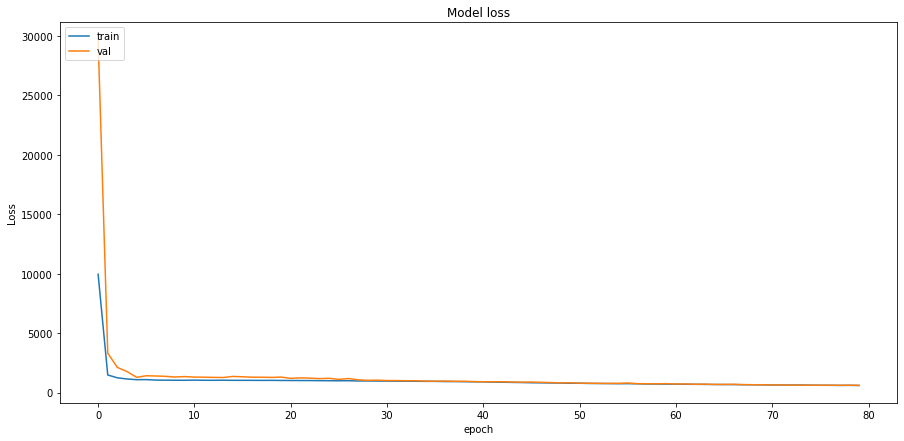

In [12]:
plot_history(history)

In [49]:
autoencoder.load_weights('simple_autoencoder_weights_neu.h5')

In [50]:
test_img_gen = img_gen.flow_from_directory('./../bloodmnist/test', target_size = IMG_SHAPE[:-1], batch_size =BATCH_SIZE, class_mode='input', color_mode ='rgb', classes = ['6_neutrophil'], shuffle=False)#,'6_neutrophil'])

Found 666 images belonging to 1 classes.


In [13]:
autoencoder.evaluate(test_img_gen)

2023-04-09 23:12:39.795965: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


42/42 [==============================] - 1s 17ms/step - loss: 0.0043


0.004322497174143791

In [51]:
test_img = test_img_gen[0][0][14]

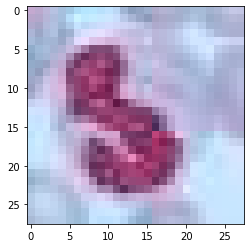

In [52]:
plt.imshow(np.array(test_img))

In [53]:
generated = autoencoder.predict(test_img.reshape(-1,28,28,3))

1/1 [==============================] - 0s 133ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


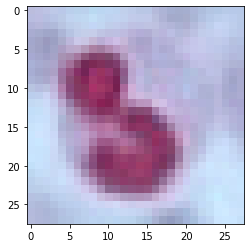

In [54]:
plt.imshow(generated.reshape(28,28,3))

In [57]:
def visualize(img,encoder,decoder):
    """Draws original, encoded and decoded images"""
    for n,i in enumerate(np.random.randint(len(img), size = 4)):
        code = encoder.predict(img[i].reshape(-1,28,28,3))  # img[None] is the same as img[np.newaxis, :]
        print(code.shape)
        reco = decoder.predict(code)[0]

        plt.subplot(1,3,1)
        plt.title("Original")
        plt.imshow(np.array(img[i].reshape(28,28,3)))

        plt.subplot(1,3,2)
        plt.title("Code")
        plt.imshow(code.reshape([code.shape[-1]//8,-1]))

        plt.subplot(1,3,3)
        plt.title("Reconstructed")
        plt.imshow(np.array(reco.reshape(28,28,3)))
        plt.show()

1/1 [==============================] - 0s 266ms/step
(1, 32)
1/1 [==============================] - 0s 96ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


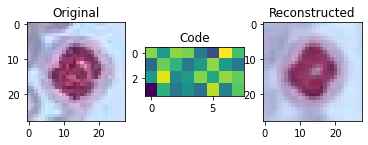

1/1 [==============================] - 0s 20ms/step
(1, 32)
1/1 [==============================] - 0s 20ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


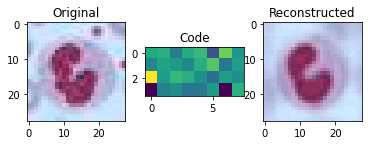

1/1 [==============================] - 0s 22ms/step
(1, 32)
1/1 [==============================] - 0s 24ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


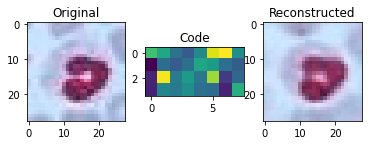

1/1 [==============================] - 0s 22ms/step
(1, 32)
1/1 [==============================] - 0s 21ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


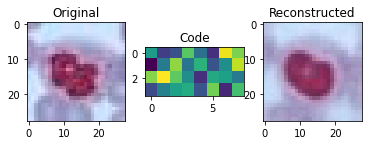

In [58]:
visualize(test_img_gen[0][0], encoder, decoder)

# Getting Decoder

In [41]:
encoder, decoder = build_autoencoder(IMG_SHAPE, code_size=32)

In [64]:
encoder_weights = autoencoder.layers[1].get_weights()
decoder_weights = autoencoder.layers[2].get_weights()

In [66]:
encoder.set_weights(encoder_weights)
decoder.set_weights(decoder_weights)

In [78]:
test_code = np.random.rand(1,32)

In [79]:
test_code

array([[0.7381518 , 0.27864467, 0.8041267 , 0.35333861, 0.45165048,
        0.13716209, 0.23338409, 0.16163159, 0.15330387, 0.25388632,
        0.6581253 , 0.56881549, 0.52282277, 0.19717174, 0.40816575,
        0.22928476, 0.29466607, 0.8081394 , 0.35496216, 0.85874807,
        0.90304649, 0.35820022, 0.15006606, 0.60554131, 0.81754984,
        0.43745231, 0.34517899, 0.27512843, 0.62321661, 0.00825038,
        0.1385732 , 0.73281946]])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


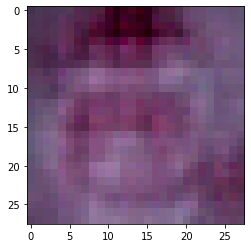

In [80]:
plt.imshow(np.array(decoder(test_code)).reshape(28,28,3))

# Pytorch

In [1]:
import torch 
import torch.nn as nn
import torch.nn.functional as F

In [257]:
class AutoEncoder(nn.Module):
    def __init__(self, img_shape, code_size):
        super(AutoEncoder, self).__init__()

        # encoder
        self.C, self.H, self.W = img_shape
        self.conv1 = nn.Conv2d(self.C, 32, kernel_size=3,  padding= "same")
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3,  padding= "same")
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3,   padding= "same")
        self.conv4 = nn.Conv2d(128, 256, kernel_size=3, padding= "same")
        self.fc1 = nn.Linear(256, code_size)

        # decoder
        self.fc3 = nn.Linear(code_size, 2304)
        self.conv5 = nn.ConvTranspose2d(256, 128, kernel_size=3, stride=2, padding=0)
        self.conv6 = nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, output_padding = 1)
        self.conv7 = nn.ConvTranspose2d(64, self.C, kernel_size=3, stride=2, padding=1, output_padding = 1)

    def encode(self, x):
        x = F.elu(self.conv1(x))
        x = F.max_pool2d(x, kernel_size=2)
        x = F.elu(self.conv2(x))
        x = F.max_pool2d(x, kernel_size=2)
        x = F.elu(self.conv3(x))
        x = F.max_pool2d(x, kernel_size=2)
        x = F.elu(self.conv4(x))
        x = F.max_pool2d(x, kernel_size=2)
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        return x

    def decode(self, z):
        z = self.fc3(z)
        z = z.view(z.size(0), 256, 3, 3)
        z = F.relu(self.conv5(z))
        z = F.relu(self.conv6(z))
        return self.conv7(z)


    def forward(self, x):
        print(x.shape)
        z = self.encode(x)
        x_recon = self.decode(z)
        return x_recon



In [13]:
z_dim = 32

In [259]:
autoencoder = AutoEncoder(img_shape = (3,28,28),code_size  = z_dim) 

In [260]:
from torchsummary import summary
summary(autoencoder.cuda(),(3,28,28))

torch.Size([2, 3, 28, 28])
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 28, 28]             896
            Conv2d-2           [-1, 64, 14, 14]          18,496
            Conv2d-3            [-1, 128, 7, 7]          73,856
            Conv2d-4            [-1, 256, 3, 3]         295,168
            Linear-5                   [-1, 32]           8,224
            Linear-6                 [-1, 2304]          76,032
   ConvTranspose2d-7            [-1, 128, 7, 7]         295,040
   ConvTranspose2d-8           [-1, 64, 14, 14]          73,792
   ConvTranspose2d-9            [-1, 3, 28, 28]           1,731
Total params: 843,235
Trainable params: 843,235
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 0.53
Params size (MB): 3.22
Estimated Total Size (MB): 3.76
----------------

In [185]:
img = np.ones((1,3,28,28))

In [188]:
tensor = torch.Tensor(img).cuda()

In [189]:
autoencoder(tensor).shape

torch.Size([1, 256, 1, 1])


torch.Size([1, 3, 28, 28])

In [ ]:
optimizer = torch.optim.Adamax(autoencoder.parameters())
loss_fn = torch.nn.MSELoss()

In [2]:
import medmnist
from medmnist import INFO, Evaluator
data_flag = 'bloodmnist'
# data_flag = 'breastmnist'
download = False

NUM_EPOCHS = 10
BATCH_SIZE = 16
lr = 0.005

info = INFO[data_flag]
task = info['task']
n_channels = info['n_channels']
n_classes = len(info['label'])

DataClass = getattr(medmnist, info['python_class'])

In [3]:
# Define dataset and dataloader
# preprocessing
import torch.utils.data as data
import torchvision.transforms as transforms

data_transform = transforms.Compose([
    transforms.ToTensor(),
])

# load the data
train_dataset = DataClass(split='train', transform=data_transform, download=download)
test_dataset = DataClass(split='test', transform=data_transform, download=download)

val_dataset = DataClass(split='val', download=download)


In [4]:
neu_train_dataset = DataClass(split = 'train', transform=data_transform)
neu_val_dataset = DataClass(split = 'val', transform=data_transform)
neu_test_dataset = DataClass(split = 'test', transform=data_transform)

In [5]:
import numpy as np
idx = (train_dataset.labels==6) 
neu_train_dataset.labels = train_dataset.labels[idx]
neu_train_dataset.imgs = train_dataset.imgs[idx.squeeze()]

idx = (val_dataset.labels==6) 
neu_val_dataset.labels = val_dataset.labels[idx]
neu_val_dataset.imgs = val_dataset.imgs[idx.squeeze()]

idx = (test_dataset.labels==6) 
neu_test_dataset.labels = test_dataset.labels[idx]
neu_test_dataset.imgs = test_dataset.imgs[idx.squeeze()]

In [6]:
train_loader = data.DataLoader(dataset=neu_train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = data.DataLoader(dataset=neu_val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = data.DataLoader(dataset=neu_test_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [7]:
len(train_loader)

146

In [8]:
def train_one_epoch(epoch_index, model):
    running_loss = 0.
    last_loss = 0.

    # Here, we use enumerate(training_loader) instead of
    # iter(training_loader) so that we can track the batch
    # index and do some intra-epoch reporting
    for i, data in enumerate(train_loader):
        # Every data instance is an input + label pair
        inputs, labels = data

        # Zero your gradients for every batch!
        optimizer.zero_grad()

        # Make predictions for this batch
        outputs = model(inputs)

        # Compute the loss and its gradients
        loss = loss_fn(outputs, inputs)
        loss.backward()

        # Adjust learning weights
        optimizer.step()

        # Gather data and report
        running_loss += loss.item()

    last_loss = running_loss / len(train_loader) # loss per batch
    print('Epoch {} loss: {}'.format(epoch_index, last_loss))

    return last_loss

In [9]:
def train(model, out_path):
    # Initializing in a separate cell so we can easily add more epochs to the same run
    epoch_number = 0

    N_EPOCHS = 80

    best_vloss = 1_000_000.

    for epoch in range(N_EPOCHS):
        print('EPOCH {}:'.format(epoch_number + 1))

        # Make sure gradient tracking is on, and do a pass over the data
        model.train(True)
        avg_loss = train_one_epoch(epoch_number, model)

        # We don't need gradients on to do reporting
        model.train(False)

        running_vloss = 0.0
        for i, vdata in enumerate(val_loader):
            vinputs, vlabels = vdata
            voutputs = model(vinputs)
            vloss = loss_fn(voutputs, vinputs)
            running_vloss += vloss

        avg_vloss = running_vloss / (i + 1)
        print('LOSS train {} valid {}'.format(avg_loss, avg_vloss))


        # Track best performance, and save the model's state
        if avg_vloss < best_vloss:
            best_vloss = avg_vloss
            torch.save(model.state_dict(), out_path)

        epoch_number += 1

In [160]:
saved_model = AutoEncoder(img_shape = (3,28,28),code_size  = z_dim) 
saved_model.load_state_dict(torch.load('simple_autoencoder_pytorch_model'))

<All keys matched successfully>

## Evaluation

In [166]:
running_tloss = 0.0
for i, tdata in enumerate(test_loader):
    tinputs, tlabels = tdata
    toutputs = saved_model(tinputs)
    tloss = loss_fn(toutputs, tinputs)
    running_tloss += tloss

avg_tloss = running_tloss / (i + 1)
print('LOSS test {}'.format(avg_tloss))

LOSS test 0.004784946795552969


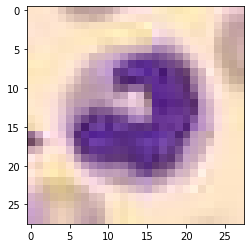

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


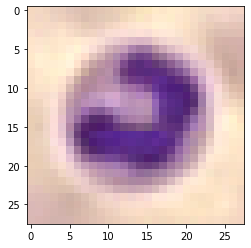

In [172]:
for i, l in test_loader:
    o = saved_model(i)
    plt.imshow(i[0].permute(1, 2, 0))
    plt.show()
    plt.imshow(o[0].permute(1, 2, 0).detach().numpy())
    plt.show()
    break
    

In [175]:
summary(autoencoder.cuda(),(3,28,28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 28, 28]             896
            Conv2d-2           [-1, 64, 14, 14]          18,496
            Conv2d-3            [-1, 128, 7, 7]          73,856
            Conv2d-4            [-1, 256, 3, 3]         295,168
            Linear-5                   [-1, 32]           8,224
            Linear-6                 [-1, 2304]          76,032
   ConvTranspose2d-7            [-1, 128, 7, 7]         295,040
   ConvTranspose2d-8           [-1, 64, 14, 14]          73,792
   ConvTranspose2d-9            [-1, 3, 28, 28]           1,731
Total params: 843,235
Trainable params: 843,235
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 0.53
Params size (MB): 3.22
Estimated Total Size (MB): 3.76
-------------------------------------------

# Using Skip Connections

In [10]:
class AutoEncoder_skip(nn.Module):
    def __init__(self, img_shape, code_size):
        super(AutoEncoder_skip, self).__init__()

        # encoder
        self.C, self.H, self.W = img_shape
        self.conv1 = nn.Conv2d(self.C, 32, kernel_size=3,  padding= "same")
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3,  padding= "same")
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3,   padding= "same")
        self.conv4 = nn.Conv2d(128, 256, kernel_size=3, padding= "same")
        self.fc1 = nn.Linear(256, code_size)

        # decoder
        self.fc3 = nn.Linear(code_size, 2304)
        self.conv5 = nn.ConvTranspose2d(256, 128, kernel_size=3, stride=2, padding=0)
        self.conv6 = nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, output_padding = 1)
        self.conv7 = nn.ConvTranspose2d(64, self.C, kernel_size=3, stride=2, padding=1, output_padding = 1)

    def forward(self, x):
        e1 = F.elu(self.conv1(x))
        m1 = F.max_pool2d(e1, kernel_size=2)
        
        e2 = F.elu(self.conv2(m1))
        m2 = F.max_pool2d(e2, kernel_size=2)
        
        e3 = F.elu(self.conv3(m2))
        m3 = F.max_pool2d(e3, kernel_size=2)
        
        e4 = F.elu(self.conv4(m3))
        m4 = F.max_pool2d(e4, kernel_size=2)
        
        f1 = m4.view(m4.size(0), -1) 
        
        z = self.fc1(f1)
        
        d5 = self.fc3(z)
        
        d4 = d5.view(d5.size(0), 256, 3, 3)
        c1 = d4+e4
        d3 = F.elu(self.conv5(c1))
        c2 = d3+e3
        d2 = F.elu(self.conv6(c2))
        c3 = d2+e2
        d1 = self.conv7(c3)
        return d1

In [14]:
autoencoder_skip = AutoEncoder_skip(img_shape = (3,28,28),code_size  = z_dim)

In [17]:
optimizer = torch.optim.Adamax(autoencoder_skip.parameters())
loss_fn = torch.nn.MSELoss()

In [18]:
train(autoencoder_skip, 'skip_autoencoder_pytorch_model')

EPOCH 1:
Epoch 0 loss: 0.013532337367419817
LOSS train 0.013532337367419817 valid 0.004240765701979399
EPOCH 2:
Epoch 1 loss: 0.0035357781054375513
LOSS train 0.0035357781054375513 valid 0.0030485913157463074
EPOCH 3:
Epoch 2 loss: 0.002707497765348382
LOSS train 0.002707497765348382 valid 0.0024685265962034464
EPOCH 4:
Epoch 3 loss: 0.0022390066248951608
LOSS train 0.0022390066248951608 valid 0.00208022678270936
EPOCH 5:
Epoch 4 loss: 0.0019301116803010338
LOSS train 0.0019301116803010338 valid 0.0018346969736739993
EPOCH 6:
Epoch 5 loss: 0.0017009794429799364
LOSS train 0.0017009794429799364 valid 0.0016212121117860079
EPOCH 7:
Epoch 6 loss: 0.001519478757049225
LOSS train 0.001519478757049225 valid 0.0014643212780356407
EPOCH 8:
Epoch 7 loss: 0.0013713881681188431
LOSS train 0.0013713881681188431 valid 0.0013216151855885983
EPOCH 9:
Epoch 8 loss: 0.0012484320857217663
LOSS train 0.0012484320857217663 valid 0.0012134036514908075
EPOCH 10:
Epoch 9 loss: 0.0011430072322270947
LOSS trai

Epoch 76 loss: 0.0001641901626374432
LOSS train 0.0001641901626374432 valid 0.0002573570527601987
EPOCH 78:
Epoch 77 loss: 0.00016603022879579628
LOSS train 0.00016603022879579628 valid 0.00027027790201827884
EPOCH 79:
Epoch 78 loss: 0.00016915624989563446
LOSS train 0.00016915624989563446 valid 0.0002571005024947226
EPOCH 80:
Epoch 79 loss: 0.0001641863302011936
LOSS train 0.0001641863302011936 valid 0.0002506989403627813


In [19]:
saved_model = AutoEncoder_skip(img_shape = (3,28,28),code_size  = z_dim) 
saved_model.load_state_dict(torch.load('skip_autoencoder_pytorch_model'))

<All keys matched successfully>

In [20]:
running_tloss = 0.0
for i, tdata in enumerate(test_loader):
    tinputs, tlabels = tdata
    toutputs = saved_model(tinputs)
    tloss = loss_fn(toutputs, tinputs)
    running_tloss += tloss

avg_tloss = running_tloss / (i + 1)
print('LOSS test {}'.format(avg_tloss))

LOSS test 0.0002527898468542844


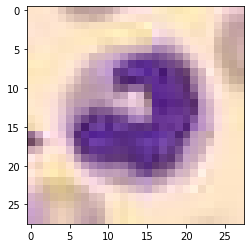

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


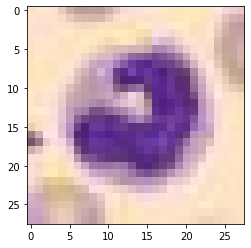

In [22]:
import matplotlib.pyplot as plt
for i, l in test_loader:
    o = saved_model(i)
    plt.imshow(i[0].permute(1, 2, 0))
    plt.show()
    plt.imshow(o[0].permute(1, 2, 0).detach().numpy())
    plt.show()
    break
    